In [1]:
from os import path
import numpy as np
import pandas as pd
import natsort
import glob
import cv2
import os
import tifffile as tiff
import imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure
import scipy.io
import anndata
from skimage.transform import warp
from skimage.draw import polygon
from PIL import Image
import seaborn as sns
import dask.array as da
import imagecodecs
import math
import skimage
from skimage import transform
import scanpy as sc
from scipy.sparse import issparse
from scipy.stats import linregress
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from IPython.display import display
from shapely.geometry import Point, Polygon

# Load Xenium Result

In [4]:
adata_xenium = sc.read_10x_h5(
    filename="path/to/file/cell_feature_matrix.h5"
)
stitched_image = np.load('stitched_images_BFP/stitched_BFP.npy')

In [5]:
csv_file_path = 'path/to/file/cell_boundaries.csv.gz'
cell_boundaries_csv = pd.read_csv(csv_file_path)

cell_boundaries_csv['vertex_x_coord'] = cell_boundaries_csv['vertex_x']/0.2125
cell_boundaries_csv['vertex_y_coord'] = cell_boundaries_csv['vertex_y']/0.2125

affine_matrix = np.loadtxt('path/to/file/matrix.csv', delimiter=',')
affine_matrix_inv = np.linalg.inv(affine_matrix)

homogeneous_coordinates = np.hstack([cell_boundaries_csv[['vertex_x_coord', 'vertex_y_coord']].values, 
                                     np.ones((cell_boundaries_csv.shape[0], 1))])
transformed_coordinates = homogeneous_coordinates.dot(affine_matrix_inv.T)
cell_boundaries_csv['x_transformed'] = transformed_coordinates[:, 0]
cell_boundaries_csv['y_transformed'] = transformed_coordinates[:, 1]

cell_boundaries_csv['x_transformed'] = round(cell_boundaries_csv['x_transformed']).astype(int)
cell_boundaries_csv['y_transformed'] = round(cell_boundaries_csv['y_transformed']).astype(int)


In [6]:
cell_boundaries_csv_agg = cell_boundaries_csv.groupby('cell_id').agg({
    'x_transformed': ['min', 'max'],
    'y_transformed': ['min', 'max']
})
cell_boundaries_csv_agg.columns = ['_'.join(c) for c in cell_boundaries_csv_agg.columns]

In [7]:
valid_ids = cell_boundaries_csv_agg[
    (cell_boundaries_csv_agg['x_transformed_min'] >= 0) &
    (cell_boundaries_csv_agg['x_transformed_max'] < stitched_image.shape[1]) &
    (cell_boundaries_csv_agg['y_transformed_min'] >= 0) &
    (cell_boundaries_csv_agg['y_transformed_max'] < stitched_image.shape[0])
].index

cell_boundaries_csv = cell_boundaries_csv[cell_boundaries_csv['cell_id'].isin(valid_ids)]

In [8]:
cell_boundaries_csv

cell_id   vertex_x   vertex_y  label_id  vertex_x_coord  \
100      aaackeij-1  1073.5500  21531.775         5     5052.000000   
101      aaackeij-1  1072.7001  21531.988         5     5048.000471   
102      aaackeij-1  1071.0000  21532.625         5     5040.000000   
103      aaackeij-1  1069.5126  21533.477         5     5033.000471   
104      aaackeij-1  1068.6625  21534.540         5     5029.000000   
...             ...        ...        ...       ...             ...   
2949986  oikfhiem-1  3089.7500  11613.763    118403    14540.000000   
2949987  oikfhiem-1  3089.3252  11613.551    118403    14538.000941   
2949988  oikfhiem-1  3088.9001  11613.551    118403    14536.000471   
2949989  oikfhiem-1  3088.6875  11613.338    118403    14535.000000   
2949990  oikfhiem-1  3086.7751  11613.338    118403    14526.000471   

         vertex_y_coord  x_transformed  y_transformed  
100       101326.000000           1140          60707  
101       101327.002353           1138          60708  
102       101330.000000           1133          60710  
103       101334.009412           1128          60712  
104       101339.011765           1125          60715  
...                 ...            ...            ...  
2949986    54653.002353           7335          30174  
2949987    54652.004706           7334          30173  
2949988    54652.004706           7333          30173  
2949989    54651.002353           7332          30173  
2949990    54651.002353           7326          30173  

[2756932 rows x 8 columns]

# Load CellTrack with Spots

In [9]:
folder = "Track_Cell_Result"
all_files = glob.glob(os.path.join(folder, "Field*_track_cell.csv"))
all_files.sort()

df_list = []
for f in all_files:
    df = pd.read_csv(f)
    df_list.append(df)
combined = pd.concat(df_list, ignore_index=True)
combined['positions_out_cell'] = combined['total_positions'] - combined['positions_in_cell']
combined = combined[
    (combined['positions_in_cell'] > 2) &
    (combined['positions_out_cell'] > 2) &
    (combined['total_positions'] > 5)
]

/tmp/ipykernel_598427/3518745698.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(df_list, ignore_index=True)


In [ ]:
per_cell = (
    combined
      .groupby("cell_id")[["TRACK_MEAN_SPEED","TRACK_DISPLACEMENT","TOTAL_DISTANCE_TRAVELED",
          "CONFINEMENT_RATIO","LINEARITY_OF_FORWARD_PROGRESSION","MEAN_DIRECTIONAL_CHANGE_RATE"]]
      .mean()
      .rename(columns={
          "TRACK_MEAN_SPEED":"mean_speed_per_cell","TRACK_DISPLACEMENT":"mean_displacement_per_cell",
          "TOTAL_DISTANCE_TRAVELED":"mean_total_distance_per_cell","CONFINEMENT_RATIO":"mean_confinement_ratio",
          "LINEARITY_OF_FORWARD_PROGRESSION":"mean_linearity_of_forward_progression",
          "MEAN_DIRECTIONAL_CHANGE_RATE":"mean_directional_change_rate",}))
per_cell["track_count"] = (combined.groupby("cell_id")["TRACK_ID"].nunique())
for col in list(per_cell.columns):per_cell[f"log1p_{col}"] = np.log1p(per_cell[col])

In [ ]:
adata_xenium.obs['total_counts'] = adata_xenium.X.sum(axis=1).A1
num_cells_800 = (adata_xenium.obs['total_counts'] >= 800).sum()
adata_filtered = adata_xenium[adata_xenium.obs['total_counts'] >= 800].copy()
sgRNA_genes = [gene for gene in adata_filtered.var_names if '-' in gene and not 'HLA' in gene]
sgRNA_to_target = {sg: sg.split('-')[0] for sg in sgRNA_genes}

idxs = [adata_filtered.var_names.get_loc(g) for g in sgRNA_genes]
mat = adata_filtered.X[:, idxs]
if issparse(mat):
    mat = mat.toarray()
bin_mat = (mat > 0).astype(int)
df_ind = pd.DataFrame(
    bin_mat,
    index=adata_filtered.obs_names,
    columns=[g for g in sgRNA_genes]
)
adata_filtered.obs = adata_filtered.obs.join(df_ind)

obs_clean = adata_filtered.obs.drop(columns=["total_counts"], errors="ignore")
gene_cols = [g for g in sgRNA_genes if g in obs_clean.columns]

counts = obs_clean[gene_cols].sum(axis=0).sort_values(ascending=False)
counts_df = pd.DataFrame({
    "gene":  counts.index,
    "count": counts.values
})
counts_df["rank"] = counts_df["count"].rank(ascending=False, method="dense")

top4 = counts_df.loc[:3, 'gene'].tolist()
remaining = [
    col for col in adata_filtered.obs.columns
    if col not in top4 + ['total_counts']
]
adata_filtered.obs['sgRNA_Gene_count'] = (
    adata_filtered.obs[remaining].sum(axis=1)
)
adata_filtered.obs['perturbation'] = np.where(
    adata_filtered.obs['sgRNA_Gene_count'] > 0,
    'perturbed',
    'unperturbed'
)
cell_perturb_ind = adata_filtered.obs.copy()[['sgRNA_Gene_count', 'perturbation']]

In [ ]:
obs = adata_filtered.obs[remaining]
sgRNA_cols = [col for col in obs.columns if "-" in col]

gene_names = sorted({col.split("-", 1)[0] for col in sgRNA_cols})
perturb_df = pd.DataFrame(index=obs.index, columns=gene_names, dtype="object")

for gene in gene_names:
    matching_cols = [col for col in sgRNA_cols if col.startswith(gene + "-")]
    if not matching_cols:
        continue

    sub_df = obs[matching_cols]
    any_positive = (sub_df > 0).any(axis=1)
    perturb_df[gene] = any_positive.map({True: "perturbed", False: "unperturbed"})
for gene in gene_names:
    colname = f"{gene}_perturb_status"
    adata_filtered.obs[colname] = perturb_df[gene]

In [ ]:
combined_sub = (
    combined
      .merge(
         per_cell['track_count'].rename('track_count'),
         left_on='cell_id', right_index=True, how='inner'
      )
      .query("track_count > 1")
)

conds = ["BNC2", "ISL1", "LHX9", "Negative_control",'EBF1','ID2']
combined_sub = combined_sub.merge(
    perturb_df[conds],
    left_on='cell_id', right_index=True,
    how='inner'
)

mask_one = (combined_sub[conds] == "perturbed").sum(axis=1) == 1
combined_sub = combined_sub[mask_one].copy()

for c in conds:
    combined_sub[f"{c}"] = (combined_sub[c] == "perturbed").astype(int)


In [ ]:
base_dir = "TrackMateResults"
dfs = []

for fov, sub in combined_sub.groupby("FOV"):
    fov_str = f"{int(fov):04d}"
    spot_file = os.path.join(
        base_dir,
        f"Field{fov_str}",
        f"Field{fov_str}_stack-spots.csv"
    )
    if not os.path.exists(spot_file):
        continue
    spots = pd.read_csv(
        spot_file,
        header=0,
        skiprows=[1, 2, 3],
        index_col=0
    )
    if "TRACK_ID" not in spots.columns:
        raise ValueError(f"{spot_file} missing TRACK_ID column")
    merged = sub.merge(
        spots[["TRACK_ID", "POSITION_X", "POSITION_Y", "FRAME"]],
        on="TRACK_ID",
        how="left"
    )
    dfs.append(merged)
    
combined_sub_with_spots = pd.concat(dfs, ignore_index=True)

In [ ]:
combined_sub_with_spots['POSITION_X_p'] = (combined_sub_with_spots['POSITION_X'] * 100).clip(upper=1999)
combined_sub_with_spots['POSITION_Y_p'] = (combined_sub_with_spots['POSITION_Y'] * 100).clip(upper=1999)
combined_sub_with_spots = combined_sub_with_spots.assign(
    col=combined_sub_with_spots['POSITION_X_p'].round().astype(int),
    row=combined_sub_with_spots['POSITION_Y_p'].round().astype(int),
)

In [ ]:
#combined_sub_with_spots.to_csv("combined_tracks_and_cells_sub_spots.csv",index=False)

In [11]:
combined_sub_with_spots

TRACK_ID     cell_id  positions_in_cell  total_positions  TRACK_INDEX  \
0             92  boklgidh-1                  8               36           92   
1             92  boklgidh-1                  8               36           92   
2             92  boklgidh-1                  8               36           92   
3             92  boklgidh-1                  8               36           92   
4             92  boklgidh-1                  8               36           92   
...          ...         ...                ...              ...          ...   
448473      4284  gmoelmec-1                  7               15         4284   
448474      4284  gmoelmec-1                  7               15         4284   
448475      4284  gmoelmec-1                  7               15         4284   
448476      4284  gmoelmec-1                  7               15         4284   
448477      4284  gmoelmec-1                  7               15         4284   

        NUMBER_SPOTS  NUMBER_GAPS  NUMBER_SPLITS  NUMBER_MERGES  \
0                 36            0              0              0   
1                 36            0              0              0   
2                 36            0              0              0   
3                 36            0              0              0   
4                 36            0              0              0   
...              ...          ...            ...            ...   
448473            15            0              0              0   
448474            15            0              0              0   
448475            15            0              0              0   
448476            15            0              0              0   
448477            15            0              0              0   

        NUMBER_COMPLEX  ...  Negative_control  EBF1  ID2  POSITION_X  \
0                    0  ...                 0     0    0   18.756505   
1                    0  ...                 0     0    0   18.737261   
2                    0  ...                 0     0    0   18.760368   
3                    0  ...                 0     0    0   18.761273   
4                    0  ...                 0     0    0   18.746130   
...                ...  ...               ...   ...  ...         ...   
448473               0  ...                 0     0    0    9.821304   
448474               0  ...                 0     0    0    9.813710   
448475               0  ...                 0     0    0    9.716473   
448476               0  ...                 0     0    0    9.697467   
448477               0  ...                 0     0    0    9.812768   

        POSITION_Y  FRAME  POSITION_X_p  POSITION_Y_p   col   row  
0        17.800330     10   1875.650546   1780.032974  1876  1780  
1        17.807990     25   1873.726145   1780.799011  1874  1781  
2        17.799584      6   1876.036849   1779.958354  1876  1780  
3        17.798815      3   1876.127290   1779.881496  1876  1780  
4        17.802023     31   1874.612969   1780.202306  1875  1780  
...            ...    ...           ...           ...   ...   ...  
448473   13.597827     48    982.130400   1359.782661   982  1360  
448474   13.598883     47    981.371018   1359.888295   981  1360  
448475   13.535158     37    971.647294   1353.515828   972  1354  
448476   13.496347     41    969.746734   1349.634693   970  1350  
448477   13.603642     46    981.276787   1360.364210   981  1360  

[448478 rows x 46 columns]

In [12]:
combined_sub_with_spots.columns

Index(['TRACK_ID', 'cell_id', 'positions_in_cell', 'total_positions',
       'TRACK_INDEX', 'NUMBER_SPOTS', 'NUMBER_GAPS', 'NUMBER_SPLITS',
       'NUMBER_MERGES', 'NUMBER_COMPLEX', 'LONGEST_GAP', 'TRACK_DURATION',
       'TRACK_START', 'TRACK_STOP', 'TRACK_DISPLACEMENT', 'TRACK_X_LOCATION',
       'TRACK_Y_LOCATION', 'TRACK_Z_LOCATION', 'TRACK_MEAN_SPEED',
       'TRACK_MAX_SPEED', 'TRACK_MIN_SPEED', 'TRACK_MEDIAN_SPEED',
       'TRACK_STD_SPEED', 'TRACK_MEAN_QUALITY', 'TOTAL_DISTANCE_TRAVELED',
       'MAX_DISTANCE_TRAVELED', 'CONFINEMENT_RATIO',
       'MEAN_STRAIGHT_LINE_SPEED', 'LINEARITY_OF_FORWARD_PROGRESSION',
       'MEAN_DIRECTIONAL_CHANGE_RATE', 'FOV', 'positions_out_cell',
       'track_count', 'BNC2', 'ISL1', 'LHX9', 'Negative_control', 'EBF1',
       'ID2', 'POSITION_X', 'POSITION_Y', 'FRAME', 'POSITION_X_p',
       'POSITION_Y_p', 'col', 'row'],
      dtype='object')

In [13]:
combined_sub_with_spots_ISL1 = combined_sub_with_spots[combined_sub_with_spots['ISL1'] == 1]
combined_sub_with_spots_NC = combined_sub_with_spots[combined_sub_with_spots['Negative_control'] == 1]
combined_sub_with_spots_EBF1 = combined_sub_with_spots[combined_sub_with_spots['EBF1'] == 1]
combined_sub_with_spots_ID2 = combined_sub_with_spots[combined_sub_with_spots['ID2'] == 1]
combined_sub_with_spots_LHX9 = combined_sub_with_spots[combined_sub_with_spots['LHX9'] == 1]

In [16]:
cell_boundaries_csv_ISL1 = cell_boundaries_csv[cell_boundaries_csv['cell_id'].isin(combined_sub_with_spots_ISL1['cell_id'])]
cell_boundaries_csv_NC = cell_boundaries_csv[cell_boundaries_csv['cell_id'].isin(combined_sub_with_spots_NC['cell_id'])]
cell_boundaries_csv_EBF1 = cell_boundaries_csv[cell_boundaries_csv['cell_id'].isin(combined_sub_with_spots_EBF1['cell_id'])]
cell_boundaries_csv_ID2 = cell_boundaries_csv[cell_boundaries_csv['cell_id'].isin(combined_sub_with_spots_ID2['cell_id'])]
cell_boundaries_csv_LHX9 = cell_boundaries_csv[cell_boundaries_csv['cell_id'].isin(combined_sub_with_spots_LHX9['cell_id'])]


# ISL1 Kymograph

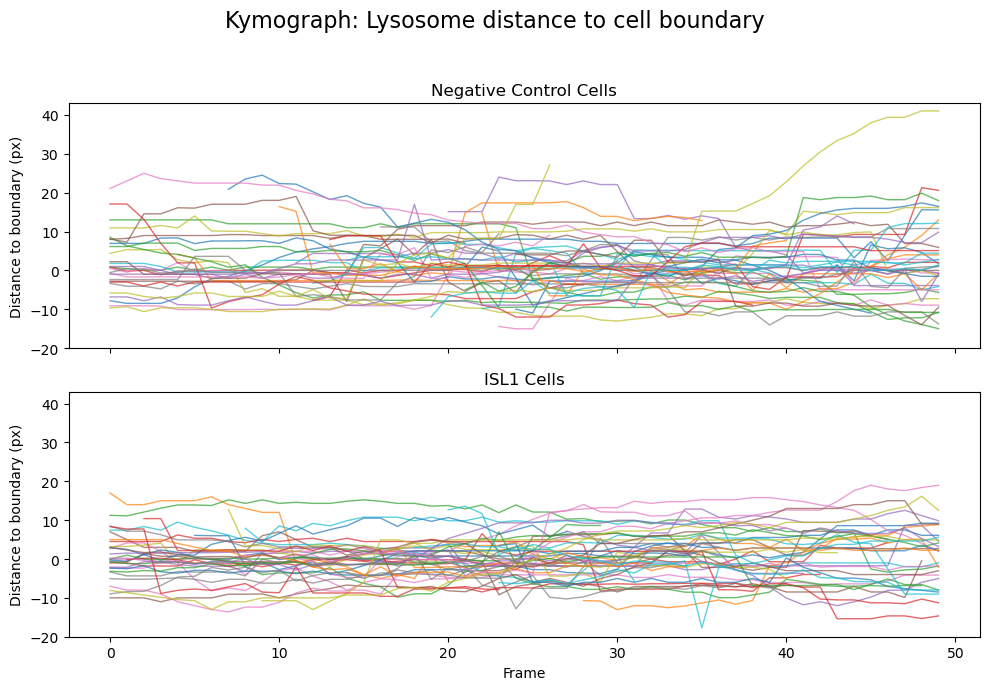

In [50]:
def compute_sub(fov):
    row = fov // 15 + 1
    col = fov % 15
    y_sub = int((row - 1) * 2000 * 0.98)
    x_sub = int((col - 1) * 2000 * 0.98)
    return x_sub, y_sub

def build_polys_and_cents(cb_df, spots_df):
    fov_map = spots_df.groupby('cell_id')['FOV'].first()
    cb = cb_df.copy()
    cb['FOV'] = cb['cell_id'].map(fov_map)
    subs = cb['FOV'].apply(compute_sub)
    cb['x_sub'], cb['y_sub'] = subs.str[0], subs.str[1]
    cb['x_transformed_subed'] = cb['x_transformed'] - cb['x_sub']
    cb['y_transformed_subed'] = cb['y_transformed'] - cb['y_sub']
    polys, cents = {}, {}
    for cid, grp in cb.groupby('cell_id'):
        poly = Polygon(zip(grp['x_transformed_subed'], grp['y_transformed_subed']))
        polys[cid] = poly
        c = poly.centroid
        cents[cid] = np.array([c.x, c.y])
    return polys, cents

def select_sample_by_percentile(spots_df, cents, low_pct=45, high_pct=55, frame_min=20, max_centroid_dist=100, n_samples=50):
    td = spots_df.groupby('TRACK_ID')['TOTAL_DISTANCE_TRAVELED'].first()
    p_low, p_high = np.percentile(td.values, [low_pct, high_pct])
    fc = spots_df.groupby('TRACK_ID')['FRAME'].nunique()
    valid = td[(td >= p_low) & (td <= p_high)].index.intersection(fc[fc >= frame_min].index)
    good = []
    for tid in valid:
        tr = spots_df[spots_df['TRACK_ID'] == tid]
        cid = tr['cell_id'].iat[0]
        pts = tr[['col','row']].values
        if np.max(np.linalg.norm(pts - cents[cid], axis=1)) < max_centroid_dist:
            good.append(tid)
    good = np.array(good)
    np.random.seed(18)
    return np.random.choice(good, size=min(n_samples, len(good)), replace=False)

def build_signed_kymo(spots_df, polys, sampled):
    frames_list, d_signed_list = [], []
    for tid in sampled:
        tr = spots_df[spots_df['TRACK_ID'] == tid].sort_values('FRAME')
        cid = tr['cell_id'].iat[0]
        pts = tr[['col','row']].values
        frames = tr['FRAME'].values
        poly = polys[cid]
        d_b = np.array([poly.boundary.distance(Point(x, y)) for x, y in pts])
        inside = np.array([poly.contains(Point(x, y)) for x, y in pts])
        d_signed = np.where(inside, -d_b, d_b)
        frames_list.append(frames)
        d_signed_list.append(d_signed)
    return frames_list, d_signed_list

# Prepare NC data
polys_NC, cents_NC = build_polys_and_cents(cell_boundaries_csv_NC, combined_sub_with_spots_NC)
sample_NC = select_sample_by_percentile(combined_sub_with_spots_NC, cents_NC,
                                        low_pct=48, high_pct=60,
                                        frame_min=20, max_centroid_dist=100, n_samples=50)
frames_NC, d_signed_NC = build_signed_kymo(combined_sub_with_spots_NC, polys_NC, sample_NC)

# Prepare ISL1 data
polys_ISL1, cents_ISL1 = build_polys_and_cents(cell_boundaries_csv_ISL1, combined_sub_with_spots_ISL1)
sample_ISL1 = select_sample_by_percentile(combined_sub_with_spots_ISL1, cents_ISL1,
                                          low_pct=48, high_pct=60,
                                          frame_min=20, max_centroid_dist=100, n_samples=50)
frames_ISL1, d_signed_ISL1 = build_signed_kymo(combined_sub_with_spots_ISL1, polys_ISL1, sample_ISL1)

# Plot combined figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(fr, ds, lw=1, alpha=0.7)
ax1.set_ylim(-20, 43)
ax1.set_ylabel("Distance to boundary (px)")
ax1.set_title("Negative Control Cells")

for fr, ds in zip(frames_ISL1, d_signed_ISL1):
    ax2.plot(fr, ds, lw=1, alpha=0.7)
ax2.set_ylim(-20, 43)
ax2.set_ylabel("Distance to boundary (px)")
ax2.set_title("ISL1 Cells")
ax2.set_xlabel("Frame")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


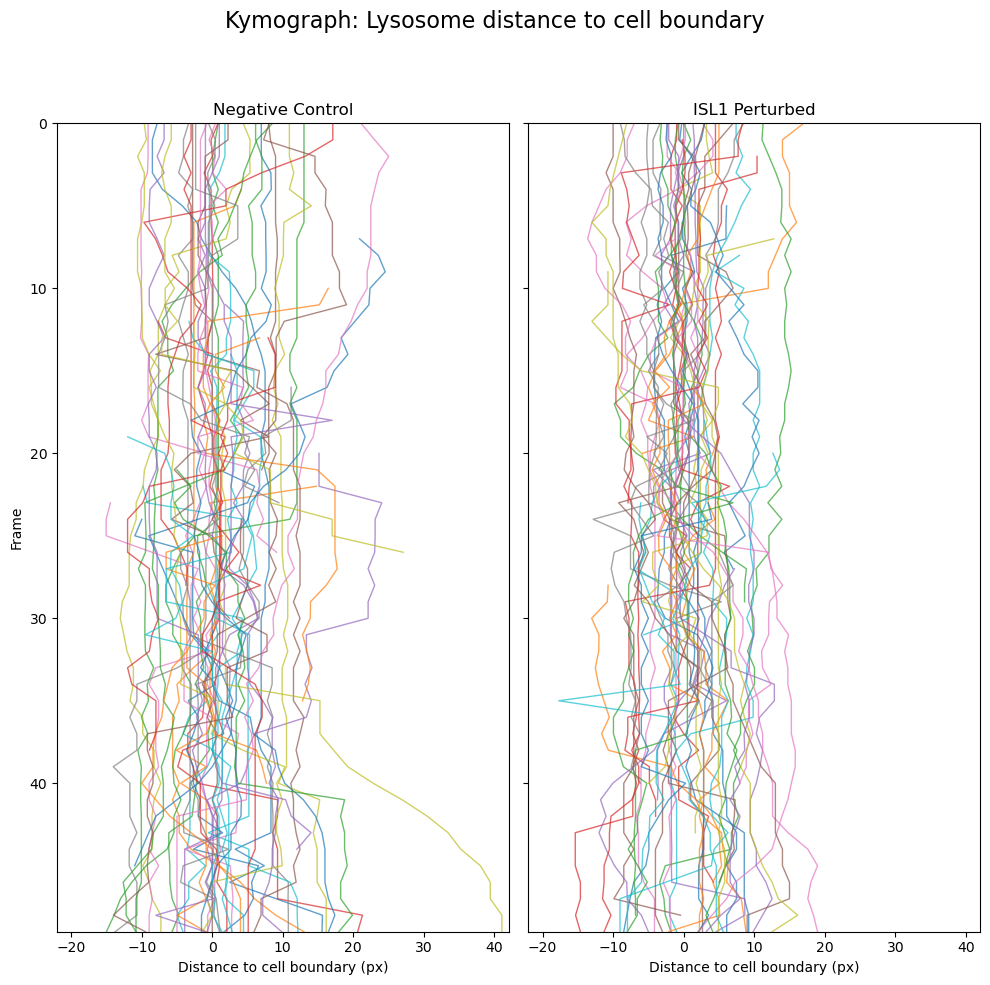

In [53]:
max_frame = max(
    max(fr.max() for fr in frames_NC),
    max(fr.max() for fr in frames_ISL1)
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(ds, fr, lw=1, alpha=0.7)
ax1.set_xlim(-22, 42)
ax1.set_ylim(max_frame, 0)
ax1.set_xlabel("Distance to cell boundary (px)")
ax1.set_ylabel("Frame")
ax1.set_title("Negative Control")

for fr, ds in zip(frames_ISL1, d_signed_ISL1):
    ax2.plot(ds, fr, lw=1, alpha=0.7)
ax2.set_xlim(-22, 42)
ax2.set_ylim(max_frame, 0)
ax2.set_xlabel("Distance to cell boundary (px)")
ax2.set_title("ISL1 Perturbed")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])

#fig.savefig("kymograph_signed_boundary_comparison_ISL1_flipped_v3.png", dpi=300, bbox_inches="tight")
plt.show()


# Others

/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


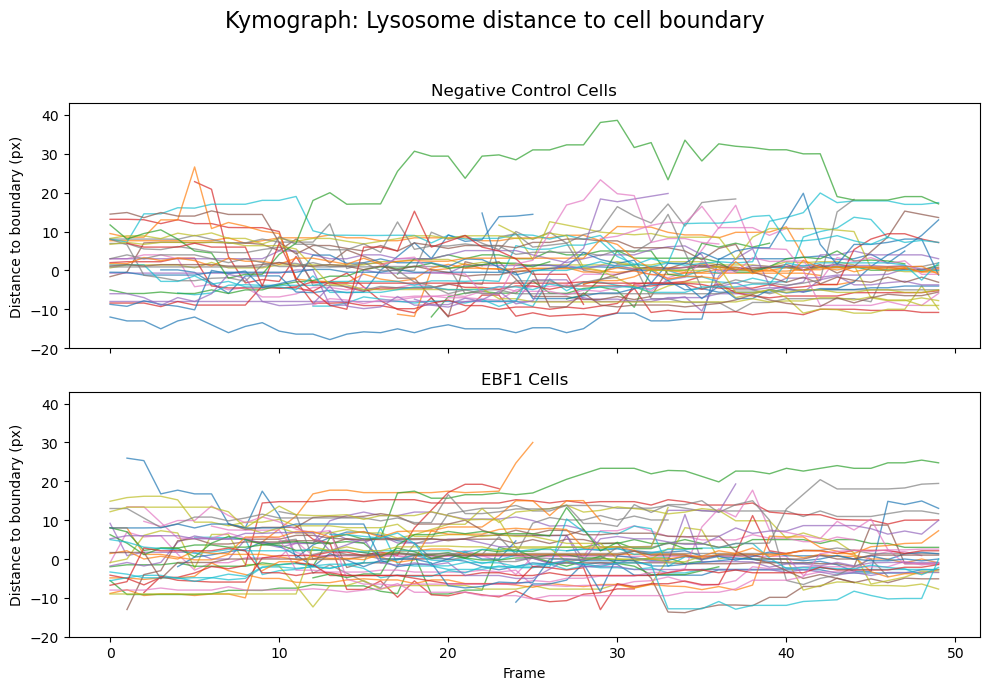

In [17]:
# Prepare NC data
polys_NC, cents_NC = build_polys_and_cents(cell_boundaries_csv_NC, combined_sub_with_spots_NC)
sample_NC = select_sample_by_percentile(combined_sub_with_spots_NC, cents_NC,
                                        low_pct=48, high_pct=60,
                                        frame_min=20, max_centroid_dist=100, n_samples=50)
frames_NC, d_signed_NC = build_signed_kymo(combined_sub_with_spots_NC, polys_NC, sample_NC)

# Prepare EBF1 data
polys_EBF1, cents_EBF1 = build_polys_and_cents(cell_boundaries_csv_EBF1, combined_sub_with_spots_EBF1)
sample_EBF1 = select_sample_by_percentile(combined_sub_with_spots_EBF1, cents_EBF1,
                                          low_pct=48, high_pct=60,
                                          frame_min=20, max_centroid_dist=100, n_samples=50)
frames_EBF1, d_signed_EBF1 = build_signed_kymo(combined_sub_with_spots_EBF1, polys_EBF1, sample_EBF1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(fr, ds, lw=1, alpha=0.7)
ax1.set_ylim(-20, 43)
ax1.set_ylabel("Distance to boundary (px)")
ax1.set_title("Negative Control Cells")

for fr, ds in zip(frames_EBF1, d_signed_EBF1):
    ax2.plot(fr, ds, lw=1, alpha=0.7)
ax2.set_ylim(-20, 43)
ax2.set_ylabel("Distance to boundary (px)")
ax2.set_title("EBF1 Cells")
ax2.set_xlabel("Frame")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


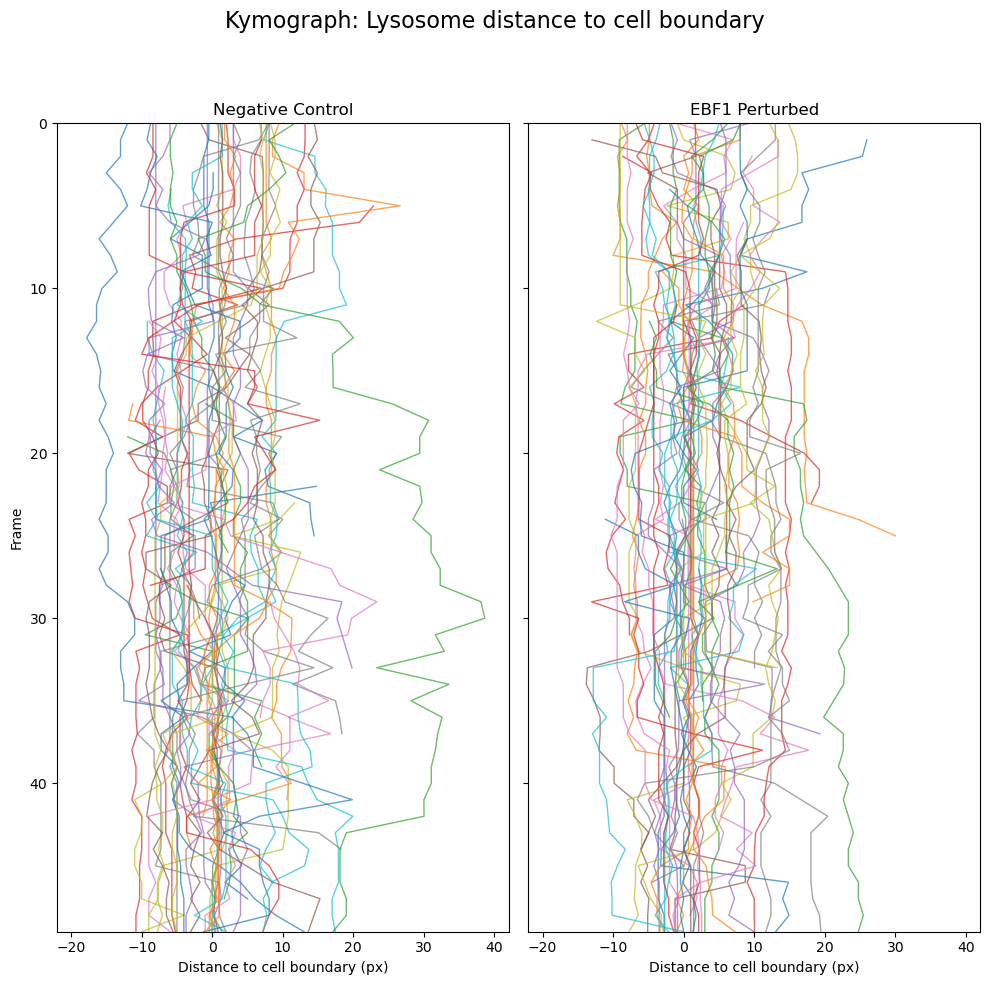

In [18]:
max_frame = max(
    max(fr.max() for fr in frames_NC),
    max(fr.max() for fr in frames_EBF1)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(ds, fr, lw=1, alpha=0.7)
ax1.set_xlim(-22, 42)
ax1.set_ylim(max_frame, 0)
ax1.set_xlabel("Distance to cell boundary (px)")
ax1.set_ylabel("Frame")
ax1.set_title("Negative Control")

for fr, ds in zip(frames_EBF1, d_signed_EBF1):
    ax2.plot(ds, fr, lw=1, alpha=0.7)
ax2.set_xlim(-22, 42)
ax2.set_ylim(max_frame, 0)
ax2.set_xlabel("Distance to cell boundary (px)")
ax2.set_title("EBF1 Perturbed")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])

#fig.savefig("kymograph_signed_boundary_comparison_EBF1_flipped.png", dpi=300, bbox_inches="tight")
plt.show()


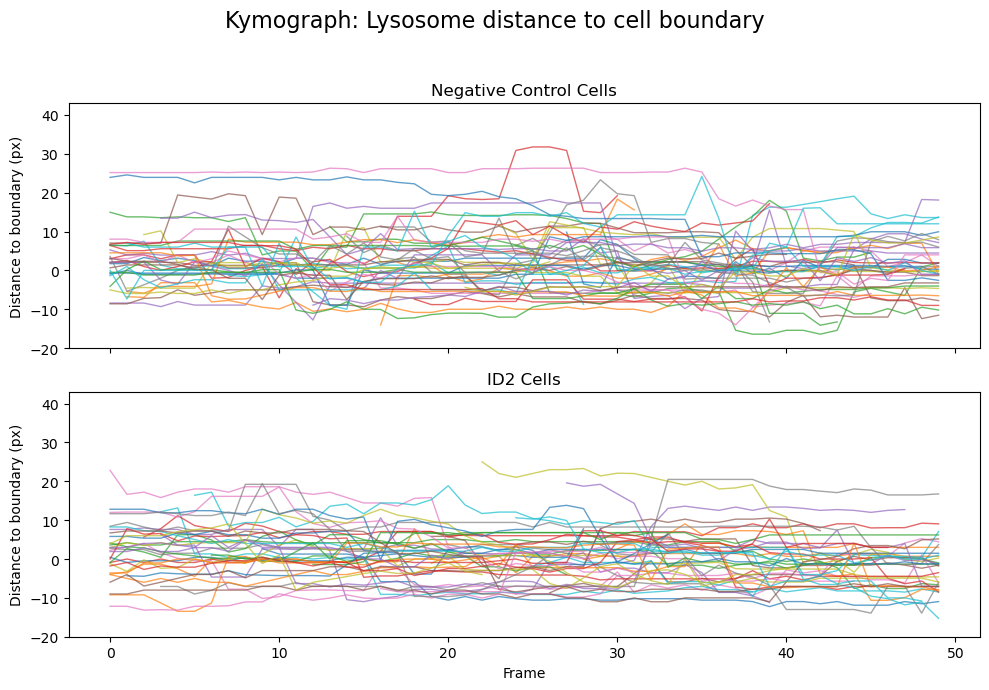

In [19]:
# Prepare NC data
polys_NC, cents_NC = build_polys_and_cents(cell_boundaries_csv_NC, combined_sub_with_spots_NC)
sample_NC = select_sample_by_percentile(combined_sub_with_spots_NC, cents_NC,
                                        low_pct=45, high_pct=65,
                                        frame_min=20, max_centroid_dist=100, n_samples=50)
frames_NC, d_signed_NC = build_signed_kymo(combined_sub_with_spots_NC, polys_NC, sample_NC)

# Prepare ID2 data
polys_ID2, cents_ID2 = build_polys_and_cents(cell_boundaries_csv_ID2, combined_sub_with_spots_ID2)
sample_ID2 = select_sample_by_percentile(combined_sub_with_spots_ID2, cents_ID2,
                                          low_pct=45, high_pct=65,
                                          frame_min=20, max_centroid_dist=100, n_samples=50)
frames_ID2, d_signed_ID2 = build_signed_kymo(combined_sub_with_spots_ID2, polys_ID2, sample_ID2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(fr, ds, lw=1, alpha=0.7)
ax1.set_ylim(-20, 43)
ax1.set_ylabel("Distance to boundary (px)")
ax1.set_title("Negative Control Cells")

for fr, ds in zip(frames_ID2, d_signed_ID2):
    ax2.plot(fr, ds, lw=1, alpha=0.7)
ax2.set_ylim(-20, 43)
ax2.set_ylabel("Distance to boundary (px)")
ax2.set_title("ID2 Cells")
ax2.set_xlabel("Frame")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [20]:
max_frame = max(
    max(fr.max() for fr in frames_NC),
    max(fr.max() for fr in frames_ID2)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(ds, fr, lw=1, alpha=0.7)
ax1.set_xlim(-22, 42)
ax1.set_ylim(max_frame, 0)
ax1.set_xlabel("Distance to cell boundary (px)")
ax1.set_ylabel("Frame")
ax1.set_title("Negative Control")

for fr, ds in zip(frames_ID2, d_signed_ID2):
    ax2.plot(ds, fr, lw=1, alpha=0.7)
ax2.set_xlim(-22, 42)
ax2.set_ylim(max_frame, 0)      # same flip
ax2.set_xlabel("Distance to cell boundary (px)")
ax2.set_title("ID2 Perturbed")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])

#fig.savefig("kymograph_signed_boundary_comparison_ID2_flipped.png", dpi=300, bbox_inches="tight")
plt.show()


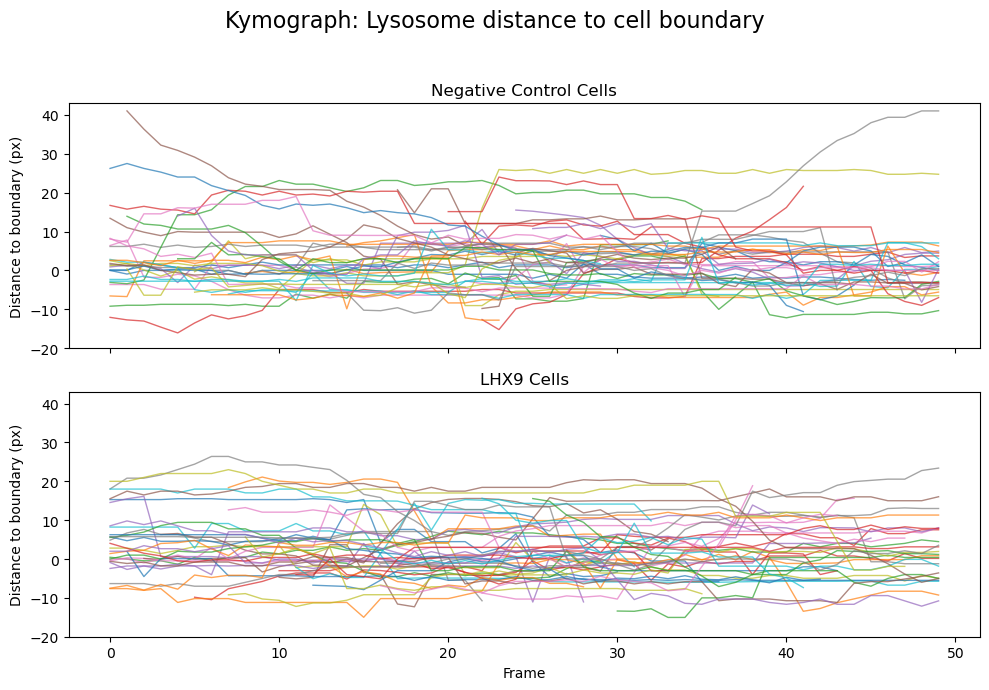

In [21]:
# Prepare NC data
polys_NC, cents_NC = build_polys_and_cents(cell_boundaries_csv_NC, combined_sub_with_spots_NC)
sample_NC = select_sample_by_percentile(combined_sub_with_spots_NC, cents_NC,
                                        low_pct=40, high_pct=65,
                                        frame_min=20, max_centroid_dist=100, n_samples=50)
frames_NC, d_signed_NC = build_signed_kymo(combined_sub_with_spots_NC, polys_NC, sample_NC)

# Prepare LHX9 data
polys_LHX9, cents_LHX9 = build_polys_and_cents(cell_boundaries_csv_LHX9, combined_sub_with_spots_LHX9)
sample_LHX9 = select_sample_by_percentile(combined_sub_with_spots_LHX9, cents_LHX9,
                                          low_pct=40, high_pct=65,
                                          frame_min=20, max_centroid_dist=100, n_samples=50)
frames_LHX9, d_signed_LHX9 = build_signed_kymo(combined_sub_with_spots_LHX9, polys_LHX9, sample_LHX9)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(fr, ds, lw=1, alpha=0.7)
ax1.set_ylim(-20, 43)
ax1.set_ylabel("Distance to boundary (px)")
ax1.set_title("Negative Control Cells")

for fr, ds in zip(frames_LHX9, d_signed_LHX9):
    ax2.plot(fr, ds, lw=1, alpha=0.7)
ax2.set_ylim(-20, 43)
ax2.set_ylabel("Distance to boundary (px)")
ax2.set_title("LHX9 Cells")
ax2.set_xlabel("Frame")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


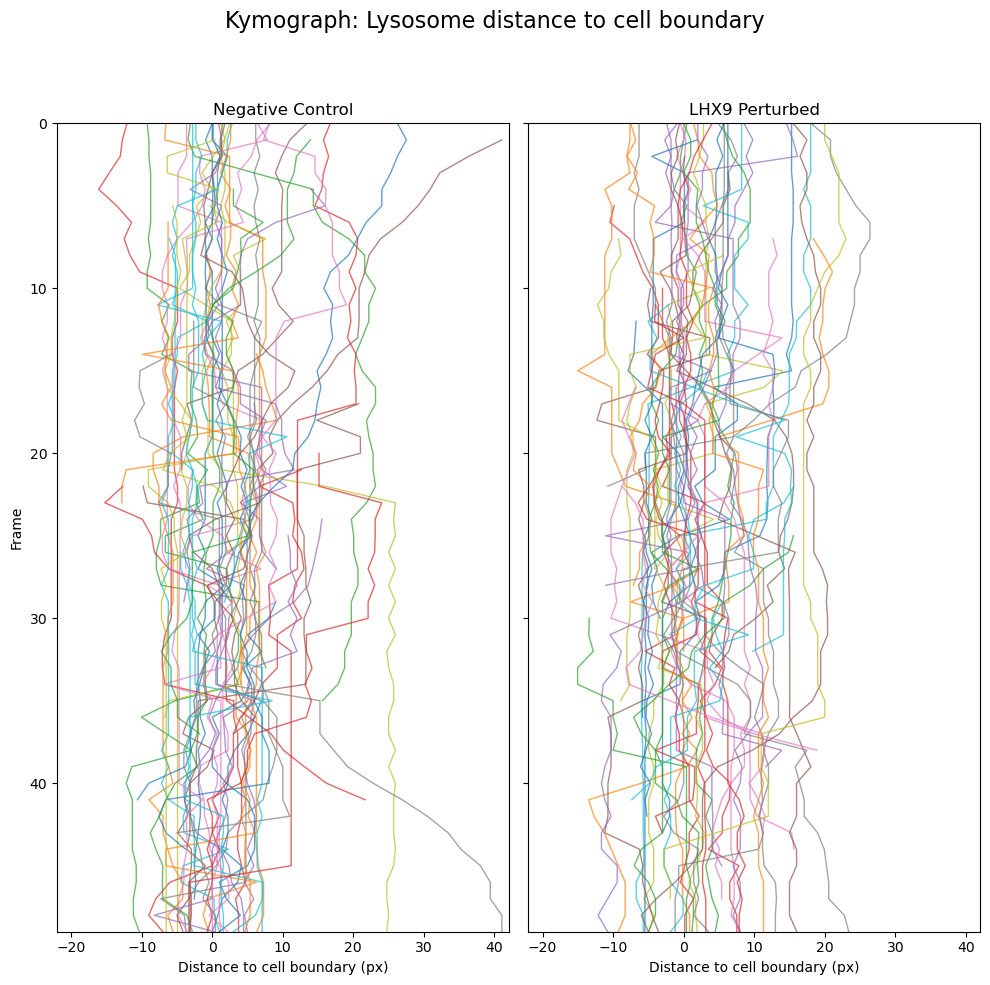

In [22]:
max_frame = max(
    max(fr.max() for fr in frames_NC),
    max(fr.max() for fr in frames_LHX9)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

for fr, ds in zip(frames_NC, d_signed_NC):
    ax1.plot(ds, fr, lw=1, alpha=0.7)
ax1.set_xlim(-22, 42)
ax1.set_ylim(max_frame, 0)
ax1.set_xlabel("Distance to cell boundary (px)")
ax1.set_ylabel("Frame")
ax1.set_title("Negative Control")

for fr, ds in zip(frames_LHX9, d_signed_LHX9):
    ax2.plot(ds, fr, lw=1, alpha=0.7)
ax2.set_xlim(-22, 42)
ax2.set_ylim(max_frame, 0)      # same flip
ax2.set_xlabel("Distance to cell boundary (px)")
ax2.set_title("LHX9 Perturbed")

fig.suptitle("Kymograph: Lysosome distance to cell boundary", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])

#fig.savefig("kymograph_signed_boundary_comparison_LHX9_flipped.png", dpi=300, bbox_inches="tight")
plt.show()
